In [1]:
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
from scipy.signal import convolve
from scipy.signal import savgol_filter
import math
import boris_extraction as boris
import pandas as pd
from scipy.stats import sem
from statistics import mean
from scipy.stats import wilcoxon

In [12]:
#TODO: you are plotting a lot of 'mua' you should make that a parameter 
# streamline the plots into one fxn?
def get_spiketrain(timestamp_array, sampling_rate):
    """
    creates a spiketrain of ms time bins 
    each array element is the number of spikes recorded per ms
    
    Args (1 total):
        timestamp_array: numpy array, spike timestamp array
        
    Returns (1):
        spiketrain_ms_timebins: a numpy array 
            array elements are number of spikes per ms 
    """
    
    hz_to_ms = int(sampling_rate*.001)
    spiketrain = np.histogram(timestamp_array, bins=np.arange(0, timestamp_array[-1], hz_to_ms))[0]
    
    return spiketrain
    
def get_firing_rate(spiketrain, smoothing_window = 250, timebin = 1):
    """
    calculates firing rate (spikes/second)
    
    Args (3 total, 1 required):
        spiketrain: numpy array, in 1 ms time bin
        smoothing_window: int, default = 250, smoothing average window (ms)
            min smoothing_window = 1
        timebin: int, default = 1, window (ms) of firing rates returned

    Return (1):
        firing_rate: numpy array of firing rates in timebin sized windows
        
    """ 
#timebinnign should be done with histogram 
# if i pad this makes this so much easier 
    if timebin != 1:
        current_timebin = 0
        temp_spiketrain = np.zeros(math.ceil(len(spiketrain)/timebin))
        for i in range(0, len(spiketrain), timebin):
            try:
                temp_spiketrain[current_timebin] = sum(spiketrain[i:i+timebin])
                current_timebin += 1
            except IndexError:
                #should i pad here or just drop it? 
                temp_spiketrain[current_timebin] = sum(spiketrain[i:])
        spiketrain = temp_spiketrain
    weights = np.ones(smoothing_window) / smoothing_window * 1000
    firing_rate = np.convolve(spiketrain, weights, mode='same')

    return firing_rate

def get_event_lengths(events):
    event_lengths = []
    for i in range(events.shape[0]):
        event_length = int(events[i][1] - events[i][0])
        event_lengths.append(event_length)
    return max(event_lengths), event_lengths

def trim_event(event, max_event):
    if event[1] - event[0] > (max_event*1000):
        event[1] = event[0]+(max_event*1000)
        event[0] = event[0]  
    return np.array(event)
    
def pre_event_window(event, baseline_window):
    event = [event[0] - (baseline_window*1000)-1, event[0]-1]
    return np.array(event)
        
def max_events(dict, max_event, pre_window):
    snippets_dict = {}
    for unit in dict.keys():
        events = dict[unit]
        try:
            events = [event[0:(pre_window + max_event)*1000] for event in events]
        except IndexError:
            pass
        snippets_dict[unit] = events
    return snippets_dict
    
class EphysRecording:
    """
    A class for an ephys recording after being spike sorted and manually curated using phy. 
    Ephys recording must have a phy folder. 

    Attributes:
        path: str, relative path to the phy folder
            formatted as: './folder/folder/phy'
        sampling_rate: int, sampling rate of the ephys device
            in Hz, standard in the PC lab is 20,000Hz
        labels_dict: dict, keys are unit ids (str) and
            values are labels (str)
        timestamps_var: numpy array, all spike timestamps 
            of good and mua units (no noise unit-generated spikes)
        unit_array: numpy array, unit ids associated with each
            spike in the timestamps_var
        unit_timestamps: dict, keys are unit ids (int), and
            values are numpy arrays of timestamps for all spikes 
            from that unit 
        unit_spiketrains: dict, keys are unit ids (??), and
            values are numpy arrays of spiketrains for that unit
            in 1 ms timebins
        unit_firing_rates: dict, keys are unit ids (??) and
            values are numpy arrays of firing rates for that unit

    Methods: 
        get_unit_labels:
        get_spike_specs:
        get_unit_timestamps:
        get_spiketrain:
        get_firing_rate:
        get_unit_spiketrains:
        get_unit_firing_rates:
        get_event_spiketrains: 
        get_event_firing_rates:
        get_unit_event_firing_rates:
        wilcoxon_average_firingrates:
    """
    def __init__(self, path, sampling_rate=20000):
        """
        constructs all necessary attributes for the EphysRecording object. 
        
        Arguments (2 total):
            path: str, relative path to the phy folder
                formatted as: './folder/folder/phy'
            sampling_rate: int, default=20000; sampling rate of 
                the ephys device in Hz
        Returns:
            None
        """
        self.path = path
        self.sampling_rate = sampling_rate
        self.get_unit_labels()
        self.get_spike_specs()
        self.get_whole_spiketrain()
        self.get_unit_timestamps()
        self.get_unit_spiketrains()
        
    def get_unit_labels(self):
        """
        assigns self.labels_dicts as a dictionary 
        with unit id (str) as key and label as values (str)
        labels: 'good', 'mua', 'noise' 

        Arguments:
            None

        Returns:
            None
        """
        labels = 'cluster_group.tsv'
        with open(os.path.join(self.path, labels), 'r') as f:
            reader = csv.DictReader(f, delimiter='\t')
            self.labels_dict = {row['cluster_id']: row['group'] for row in reader}
            
    def get_spike_specs(self):
        """
        imports spike_time and spike_unit from phy folder
        deletes spikes from units labeled noise in unit and timestamp array
        and assigns self.timstamps_var (numpy array) as the remaining timestamps 
        and assigns self.unit_array (numpy array) as the unit ids associated
        with each spike
        
        Args:
            None
        
        Returns:
            None 
        """
        timestamps = 'spike_times.npy'
        unit = 'spike_clusters.npy'
        timestamps_var = np.load(os.path.join(self.path, timestamps))
        unit_array = np.load(os.path.join(self.path, unit))
        spikes_to_delete = []
        for spike in range(len(timestamps_var)): 
            if self.labels_dict[unit_array[spike].astype(str)] == 'noise':
                spikes_to_delete.append(spike)
        self.timestamps_var = np.delete(timestamps_var, spikes_to_delete)
        self.unit_array = np.delete(unit_array, spikes_to_delete)

    def get_unit_timestamps(self):
        """
        creates a dictionary of units to spike timestamps
        keys are unit ids (int) and values are spike timestamps for that unit (numpy arrays)
        and assigns dictionary to self.unit_timestamps
        
        Args:
            None
        
        Return:
            None
        """
        
        unit_timestamps = {}
        for spike in range(len(self.timestamps_var)): 
            if self.unit_array[spike] in unit_timestamps.keys():
                timestamp_list = unit_timestamps[self.unit_array[spike]] 
                timestamp_list = np.append(timestamp_list, self.timestamps_var[spike])
                unit_timestamps[self.unit_array[spike]] = timestamp_list
            else:
                unit_timestamps[self.unit_array[spike]] = self.timestamps_var[spike]
        
        self.unit_timestamps = unit_timestamps

    def get_whole_spiketrain(self):
        """
        creates a spiketrain of ms time bins 
        each array element is the number of spikes recorded per ms
        
        Args (1 total):
            timestamp_array: numpy array, spike timestamp array
            
        Returns (1):
            spiketrain_ms_timebins: a numpy array 
                array elements are number of spikes per ms 
        """
        self.spiketrain = get_spiketrain(self.timestamps_var, self.sampling_rate)

    def get_unit_spiketrains(self):  
        """
        Creates a dictionary and assigns it as self.unit_spiketrains
        where keys are 'good' unit ids (??) (not 'mua')
        and values are numpy arrays of spiketrains in 1 ms time bins
        
        Args:
            None
            
        Reutrns:
            None
            
        """
        unit_spiketrains = {}
        for unit in self.unit_timestamps.keys():
            if self.labels_dict[str(unit)] == 'good':
                unit_spiketrains[unit] = get_spiketrain(self.unit_timestamps[unit], self.sampling_rate)
                
        self.unit_spiketrains = unit_spiketrains

    def get_unit_firing_rates(self, smoothing_window = 250, timebin = 1):  
        """
        Calculates firing rates per unit,
        creates a dictionary and assigns it as self.unit_firing_rates
        the keys are unit ids (???) and values are firing rates for the unit (numpy array)
        
        Args (2 total):
            smoothing_window: int, default = 250, smoothing average window (ms)
                min smoothing_window = 1
            timebin: int, default = 1, window (ms) of firing rates returned
            
        Returns:
            None
        """
        unit_firing_rates = {}
        for unit in self.unit_spiketrains.keys():
            unit_firing_rates[unit] = get_firing_rate(self.unit_spiketrains[unit], smoothing_window, timebin)
        
        return unit_firing_rates
class EventTriggeredAverages:

    def __init__(self, event, events, recording, smoothing_window=250, timebin=1):
        self.recording = recording
        self.event = event
        self.events = events
        self.longest_event, self.event_lengths = get_event_lengths(events)
        self.smoothing_window = smoothing_window
        self.timebin = timebin
        self.unit_firing_rates = recording.get_unit_firing_rates(smoothing_window, timebin)
        
    def get_event_snippets(self, whole_recording, pre_window=0, post_window=0, equalize = False, events = None):
        """
        calculates spiketrains from timestamps for events
        optional pre-event and post-event windows (s) may be included
    
        Args (4 total, 2 required):
            events:numpy array of [[start (ms), stop (ms)] x n events]
            spiektrain: numpy array of spike timestamps in 1 ms windows 
            pre_window: int, default = 0, seconds prior to start of event returned
            post_window: int, default = 0, seconds after end of event returned
    
        Returns (1):
            event_spiketrains: list of lists, each item in the 
            larger list is an event spiketrain, and each item in 
            the event spiketrain list is the number of spikes per 1 ms timebin
        """
        
        if events is None:
            events = self.events
        event_snippets = []
        pre_window_ms = pre_window*1000
        post_window_ms = post_window*1000
        for i in range(events.shape[0]):
            if equalize:
                event_diff = int(self.longest_event - self.event_lengths[i])
            else:
                event_diff = 0
            pre_event = int(events[i][0] - pre_window_ms)
            post_event = int(events[i][1] + post_window_ms + event_diff)
            event_snippet = whole_recording[pre_event:post_event]
            event_snippets.append(event_snippet)
        return event_snippets

    def get_unit_event_firing_rates(self, pre_window = 0, post_window = 0, equalize = False, events = None):
        """
        calculates firing rates for events per unit
    
        Args (6 total, 1 required):
            events:numpy array of [[start (ms), stop (ms)] x n events]
            smoothing_window: int, default=250, smoothing average window (ms)
                min smoothing_window = 1 
            timebin: int, default 1, timebin in ms for firing rate array
            pre_window: int, default=0, seconds prior to start of event returned
            post_window: int, default=0, seconds after end of event returned
            equalize: Boolean, default=False, if True, equalizes lengths of each event to longest event
            
        Return (1):
            unit_event_firing_rates: dict, keys are unit ids (???),
            values are lsts of numpy arrays of firing rates per event
        """
        unit_event_firing_rates = {}
        for unit in self.recording.unit_spiketrains.keys():
            event_firing_rates = self.get_event_snippets(self.unit_firing_rates[unit], pre_window, post_window, equalize, events)
            unit_event_firing_rates[unit] = event_firing_rates
        return unit_event_firing_rates


    def wilcoxon_average_firingrates(self, baseline_window, max_event=None, equalize = False):
        #what if i wanted a random snippet from the first ten minutes instead of prior to the event?
        """
        calculates wilcoxon signed-rank test for average firing rates of two windows: event vs baseline
        baseline used is an amount of time immediately prior to the event
        wilcoxon signed-rank test is applied to two sets of measurements:
        average firing rate per event, average firing rate per baseline
        
        Args (5 total, 2 required):
            events:numpy array of [[start (ms), stop (ms)] x n events]
            baseline_window: int, length of baseline firing rate (s)
            max_event: int, default=0, max length of an event (s)
            smoothing_window: int, default=250, smoothing average window (ms)
                min smoothing_window = 1 
            timebin: int, default 1, timebin in ms for firing rate array
    
        Return (1):
            wilcoxon_df: pandas dataframe, columns are unit ids, 
            row[0] are wilcoxon statistics and row[1] are p values 
        
        """
        preevent_baselines = np.array([pre_event_window(event, baseline_window) for event in self.events])
        unit_preevent_firing_rates = self.get_unit_event_firing_rates(0,0,False,preevent_baselines)
        unit_event_firing_rates = self.get_unit_event_firing_rates(0,0,equalize)
        print(unit_event_firing_rates)
        if max_event is not None:
            unit_event_firing_rates = max_events(unit_event_firing_rates, max_event, 0)
        unit_averages = {}
        for unit in unit_event_firing_rates:
            print(unit)
            event_averages = [mean(event) for event in unit_event_firing_rates[unit]]
            preevent_averages = [mean(event) for event in unit_preevent_firing_rates[unit]]
            unit_averages[unit] = [event_averages, preevent_averages]
        wilcoxon_stats = {}
        for unit in unit_averages.keys(): 
            wilcoxon_stats[unit] = wilcoxon(unit_averages[unit][0], unit_averages[unit][1], method = 'approx')
        wilcoxon_df = pd.DataFrame.from_dict(wilcoxon_stats)
        self.baseline_window = baseline_window
        self.max_event = max_event
        self.wilcoxon_df = wilcoxon_df

        return unit_averages
        
    def eda_wilcoxon_event_plots(self, p_value=None):
        #TODO: either use max_event or equalize methods for making all events the same length
        """
        plot event triggered average firing rates for units
        all events need to be the same length
        
        """ 
        units_to_plot = []
        if p_value is not None:
            for unit in self.unit_firing_rates.keys():
                if self.wilcoxon_df[unit][1] < p_value:
                      units_to_plot.append(unit)
        else:
            units_to_plot = self.recording.unit_spiketrains.keys()
        no_plots = len(units_to_plot)
        height_fig = math.ceil(no_plots/3)
        i = 1
        plt.figure(figsize=(10*height_fig, 8))
        unit_event_firing_rates = self.get_unit_event_firing_rates(self.baseline_window, 0, True)
        if self.max_event is not None:
            unit_event_firing_rates = max_events(unit_event_firing_rates, self.max_event, self.baseline_window)
        for unit in units_to_plot:
            mean_arr = np.mean(unit_event_firing_rates[unit], axis=0)
            sem_arr = sem(unit_event_firing_rates[unit], axis=0)
            p_value = self.wilcoxon_df[unit][1]
            x = np.linspace(start=-self.baseline_window,stop=self.max_event,num=len(mean_arr))
            plt.subplot(height_fig,3,i)
            plt.plot(x, mean_arr, c= 'b')
            plt.axvline(x=0, color='r', linestyle='--')
            plt.fill_between(x, mean_arr-sem_arr, mean_arr+sem_arr, alpha=0.2)
            plt.title(f'Unit {unit} Average (p={p_value})')
            i+=1
        plt.show()

In [13]:
fam = EphysRecording(path=".\\proc\\20221219_114535_6_1_fam_merged.rec\\phy", sampling_rate = 20000)

{19: [array([4., 4., 4., ..., 4., 4., 4.]), array([28., 28., 28., ..., 20., 20., 20.]), array([24., 24., 24., ..., 28., 28., 28.]), array([28., 28., 28., ..., 36., 36., 36.]), array([ 4.,  4.,  4., ..., 16., 16., 16.]), array([20., 20., 20., ..., 20., 20., 20.]), array([16., 16., 16., ..., 16., 16., 16.]), array([20., 20., 20., ..., 16., 16., 16.]), array([24., 24., 24., ..., 40., 40., 40.]), array([ 8.,  8.,  8., ..., 32., 32., 32.]), array([16., 16., 16., ..., 24., 24., 28.]), array([28., 28., 28., ..., 16., 16., 16.]), array([ 4.,  4.,  4., ..., 20., 20., 20.]), array([ 8.,  8.,  8., ..., 16., 16., 16.]), array([20., 20., 20., ..., 36., 36., 36.])], 1: [array([4., 4., 4., ..., 0., 0., 0.]), array([12., 12., 12., ..., 12., 12., 12.]), array([8., 8., 8., ..., 4., 4., 4.]), array([4., 4., 4., ..., 4., 4., 4.]), array([12., 12., 12., ...,  8.,  8.,  8.]), array([4., 4., 4., ..., 4., 4., 4.]), array([0., 0., 0., ..., 4., 4., 4.]), array([ 8.,  8.,  8., ..., 12., 12., 12.]), array([12.,  

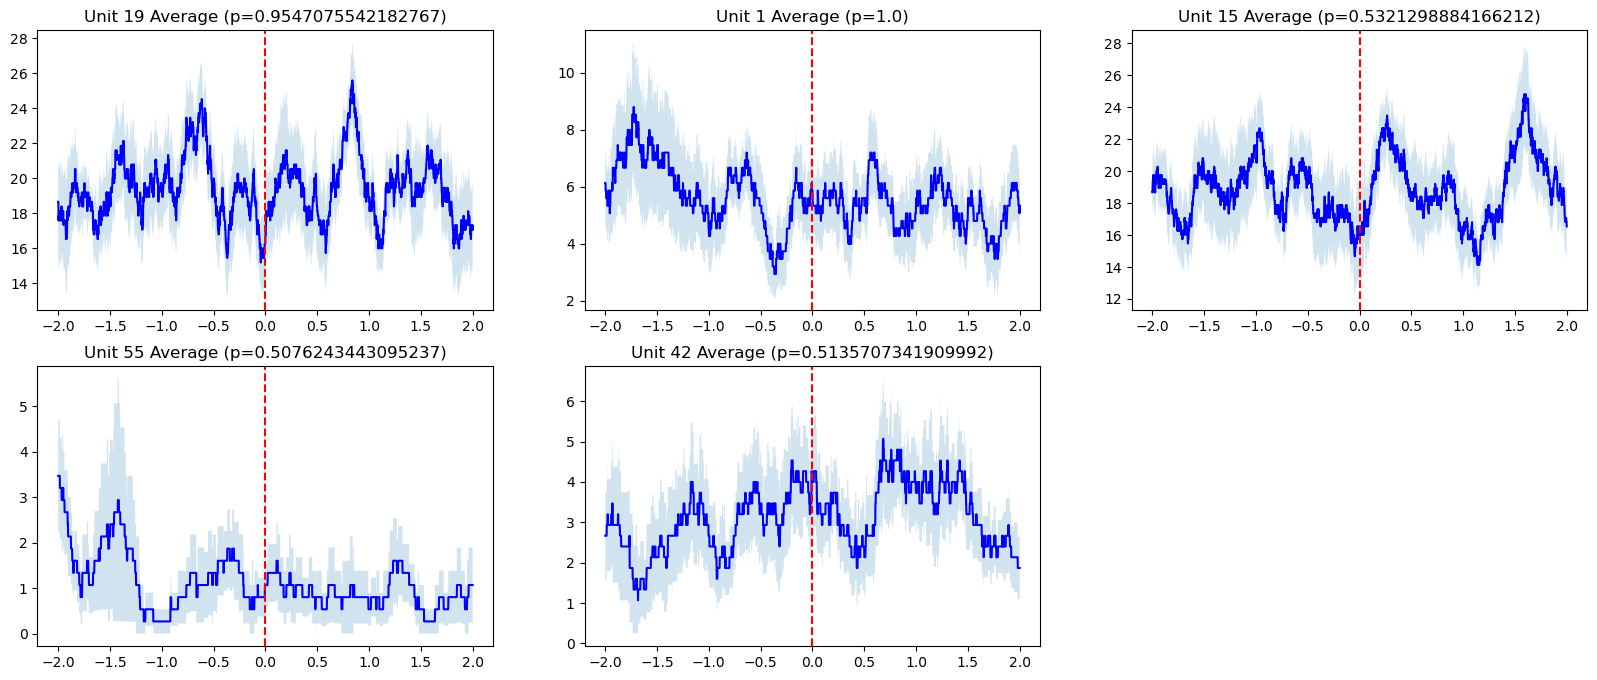

In [14]:
boris_df = pd.read_excel('C:\\Users\megha\\Documents\\Padilla-Coreano\\homecage_social_ephys_vids\\mp4vids\\annotated_behavior_cagfamnov.xlsx')
fam_df = boris_df[boris_df['Observation id'] == 'familiar_6_1_06282023']
sniffing_bouts = boris.get_behavior_bouts(fam_df, ['subject'], ['anogential sniffing', 'face sniffing'], 2, .3)
fam_sniff = EventTriggeredAverages('sniffing', sniffing_bouts, fam, 250)
fam_sniff.get_unit_event_firing_rates(2,0,True)
fam_sniff.wilcoxon_average_firingrates(2,2)
fam_sniff.eda_wilcoxon_event_plots()

In [15]:
novel = EphysRecording(path=".\\proc\\20221219_124942_6_1_novel_merged.rec\\phy", sampling_rate = 20000)
novel_df = boris_df[boris_df['Observation id'] == 'novel_6_1_06282023']
novel_sniffing_bouts = boris.get_behavior_bouts(novel_df, ['subject'], ['anogential sniffing', 'face sniffing'], 2, .3)
novel_sniff = EventTriggeredAverages('sniffing', novel_sniffing_bouts, novel, 250)
unit_event_firing_rates = novel_sniff.get_unit_event_firing_rates(2,0,True)
novel_sniff.wilcoxon_average_firingrates(2,2)
novel_sniff.eda_wilcoxon_event_plots()

{98: [array([12., 12., 12., ...,  4.,  4.,  4.]), array([4., 4., 4., ..., 8., 8., 8.]), array([16., 16., 16., ...,  4.,  4.,  4.]), array([12., 12., 12., ..., 12., 12., 12.]), array([12., 12., 12., ...,  0.,  0.,  0.]), array([8., 8., 8., ..., 4., 4., 4.]), array([4., 4., 4., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([4., 4., 4., ..., 0., 0., 0.]), array([12., 12., 12., ..., 20., 20., 20.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 4., 4., 4.]), array([0., 0., 0., ..., 8., 8., 8.])], 4: [array([12., 12., 12., ..., 28., 28., 28.]), array([28., 28., 28., ..., 12., 12., 12.]), array([4., 4., 4., ..., 8., 8., 8.]), array([12., 12., 12., ...,  4.,  4.,  4.]), array([ 4.,  4.,  4., ..., 16., 16., 16.]), array([16., 16., 16., ..., 44., 44., 44.]), array([20., 20., 20., ..., 20., 20., 20.]), array([ 4.,  4.,  4., ..., 32., 32., 32.]), array([ 4.,  4.,  4., ..., 12., 12., 12.]), array([40., 40., 40., ...,  0.,  0.,  0.]), array([12., 12., 12., ..., 28.,

StatisticsError: mean requires at least one data point

In [23]:
novel_sniff.unit_firing_rates[160]
sum(novel.unit_spiketrains[160])

73

In [18]:
fam_path = '.\\proc\\20221219_114535_6_1_fam_merged.rec\\phy'
boris_df = pd.read_excel('C:\\Users\megha\\Documents\\Padilla-Coreano\\homecage_social_ephys_vids\\mp4vids\\annotated_behavior_cagfamnov.xlsx')
fam_df = boris_df[boris_df['Observation id'] == 'familiar_6_1_06282023']
cagemate_df = boris_df[boris_df['Observation id'] == 'cagemate_6_1_06282023']
novel_df = boris_df[boris_df['Observation id'] == 'novel_6_1_06282023']

In [19]:

fam_timestamps, fam_units = get_spike_specs(fam_path)
fam_spiketrain = get_spiketrain(fam_timestamps, 20)
print(len(fam_spiketrain))
unit_labels = get_unit_labels(fam_path)
unit_dict = get_unit_timestamps(fam_timestamps, fam_units)
sniffing_bouts = boris.get_behavior_bouts(fam_df, 'subject', ['anogential sniffing', 'face sniffing'], 2, .3)
fam_event_firingrates = get_event_firing_rates(sniffing_bouts, fam_timestamps, 20, 100)

NameError: name 'get_spike_specs' is not defined

In [ ]:
mean_arr = np.mean(cagemateevent_firingrates, axis=0)
sem_arr = sem(cagemateevent_firingrates, axis=0)
x = np.array(range(len(mean_arr)))
plt.plot(.001*x, mean_arr)
plt.axvline(x=2, color='r', linestyle='--')
plt.xlim(0,5)
plt.title('Cagemate sniffing triggered population firing rate average')
#plt.fill_between(range(len(mean_arr)), mean_arr-sem_arr, mean_arr+sem_arr, alpha=0.2)
plt.show()

In [ ]:
novel_path ='.\\proc_old_backup\\20221219_124942_6_1_novel_merged.rec\\phy'
    
novel_timestamps, novel_clusters_array = get_spike_specs(novel_path)
novel_spiketrain = get_spiketrain(novel_timestamps, 20)

novel_sniffing_bouts = boris.get_behavior_bouts(novel_df, 'subject', ['anogential sniffing', 'face sniffing'], 2, .3)
novelevent_firingrates = get_event_firing_rates(novel_sniffing_bouts, novel_timestamps, 2, 1, 20, 20000)    

mean_arr = np.mean(novelevent_firingrates, axis=0)
sem_arr = sem(novelevent_firingrates, axis=0)
x = np.array(range(len(mean_arr)))
plt.plot(.001*x, mean_arr)
plt.axvline(x=2, color='r', linestyle='--')
plt.xlim(0,10)
plt.title('novel sniffing triggered population firing rate average')
#plt.fill_between(range(len(mean_arr)), mean_arr-sem_arr, mean_arr+sem_arr, alpha=0.2)
plt.show()

In [ ]:
x = np.array(range(len(fam_all_sniff)))
plt.figure(figsize = (25,5))
plt.ylim(0,35)
plt.plot(x, fam_all_sniff, c = 'r', linewidth = 2)
plt.plot(x, fam_baseline_snippet, c = 'k', linewidth = .5)
plt.title('FAM', fontsize = 40)

x = np.array(range(len(novel_all_sniff)))
plt.figure(figsize = (25,5))
plt.plot(x, novel_all_sniff, c = 'r', linewidth = 2)
plt.plot(x, novel_baseline_snippet, c = 'k', linewidth = .5)
plt.title('Novel', fontsize = 40)

x = np.array(range(len(cagemate_all_sniff)))
plt.figure(figsize = (25,5))
plt.plot(x, cagemate_all_sniff, c = 'r', linewidth = 2)
plt.plot(x, cagemate_baseline_snippet, c = 'k', linewidth = .5)
plt.title('Cagemate', fontsize = 40)